In [1]:
import sys
sys.path.append("../")
sys.path.append("../..")

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(14, 4)

In [47]:
# Input
start_time = pd.to_datetime("2021-01-01 00:00:00")
end_time = pd.to_datetime("2021-02-10 00:00:00")

durationList = ['Hour', 'Day', 'Week', 'Month','Year']
feature_cycle = 'Day'
feature_cycle_times = 1

fig_width_num = 4
fig_width = 30
fig_height = 30


modelName="som"
db_name = 'air_indoor_도서관'
ms_name = 'ICW0W2000096'

feature_name = 'in_co2'
freq_min = 60
import datetime
timedelta_frequency_sec = datetime.timedelta(minutes= freq_min)

# 3. Nan Processing Parameter
# 3-1. NanLImitProcessingInfo = {'type':'ratio', 'ConsecutiveNanLimit':0.05, 'totalNaNLimit':1} # seconds
# 3-2. NanLImitProcessingInfo = {'type':'time', 'ConsecutiveNanLimit':1*60*60, 'totalNaNLimit':5*60*60} #seconds
# 3-3.
#NanInfoForCleanData = {'type':'num', 'ConsecutiveNanLimit':2, 'totalNaNLimit':20} #27
#NanInfoForCleanData = {'type':'num', 'ConsecutiveNanLimit':1000, 'totalNaNLimit':100000}
NanInfoForClenData = {'type':'num', 'ConsecutiveNanLimit':1, 'totalNaNLimit':60} #66

## 1. data Prepration

In [48]:
from clust.ingestion.influx import influx_Client_v2 as influx_Client, multipleDataSets
from setting import influx_setting_KETI as ins
db_client = influx_Client.influxClient(ins.CLUSTDataServer2)

In [ ]:
input_data = db_client.get_data_by_time(start_time, end_time, db_name, ms_name)

In [ ]:
from clust.transformation.splitDataByCycle import dataByCycle
# 고른 프리컨시를 갖는 Cycle 데이터가 딕셔너리 형태로 제공됨
dataSet = dataByCycle.getCycleSelectDataSet(input_data, feature_cycle, feature_cycle_times)

## 2. preprocessing (refinement, error handling)

In [ ]:
# dataSet 형태기 때문에 dataSet형태의 전처리가 필요함

from Clust.clust.ingestion.mongo import customModules
from Clust.clust.ingestion.mongo import mongo_Client
#db에서 가져온 데이터로 만든 민맥스
mongo_client = mongo_Client.mongoClient(ins.CLUSTMetaInfo2)
min_max_from_db = customModules.get_min_max_info_from_bucketMeta(mongo_client, db_name)
print(min_max_from_db)
#필수적인 오류 데이터에 대해서 NaN 처리함
from clust.preprocessing.dataPreprocessing import DataProcessing
CertainParam= {'flag': True, 'data_min_max_limit':min_max_from_db}
refine_param = {'removeDuplication': {'flag': True}, 'staticFrequency': {'flag': True, 'frequency': timedelta_frequency_sec}}
outlier_param ={
    "certainErrorToNaN":CertainParam, 
    "unCertainErrorToNaN":{'flag': False}
}
imputation_param = {"flag":False}
process_param = {'refine_param':refine_param, 'outlier_param':outlier_param, 'imputation_param':imputation_param}

partialP = DataProcessing(process_param)
multiple_dataset = partialP.multiDataset_all_preprocessing(dataSet)

## 3. get one dataframe 

In [ ]:
from Clust.clust.transformation.general import dataframe
dataDF = dataframe.get_oneDF_with_oneFeature_from_multipleDF(multiple_dataset, feature_name)

## 4. remove bad column

In [ ]:
from Clust.clust.quality.NaN import cleanData
CMS = cleanData.CleanData()
imputed_data = CMS.get_cleanData_by_removing_column(dataDF, NanInfoForClenData) 

In [ ]:
print(len(dataDF.columns))
print(len(imputed_data.columns))

## 5. Clustering

### 5-1. Preprocessing for clustering

In [44]:
from Clust.clust.ML.clustering import interface, preprocessing
from Clust.clust.ML.clustering.somClustering import SomClustering
data = imputed_data
data = preprocessing.processing_for_clustering(data, ewm_parameter=0.9)

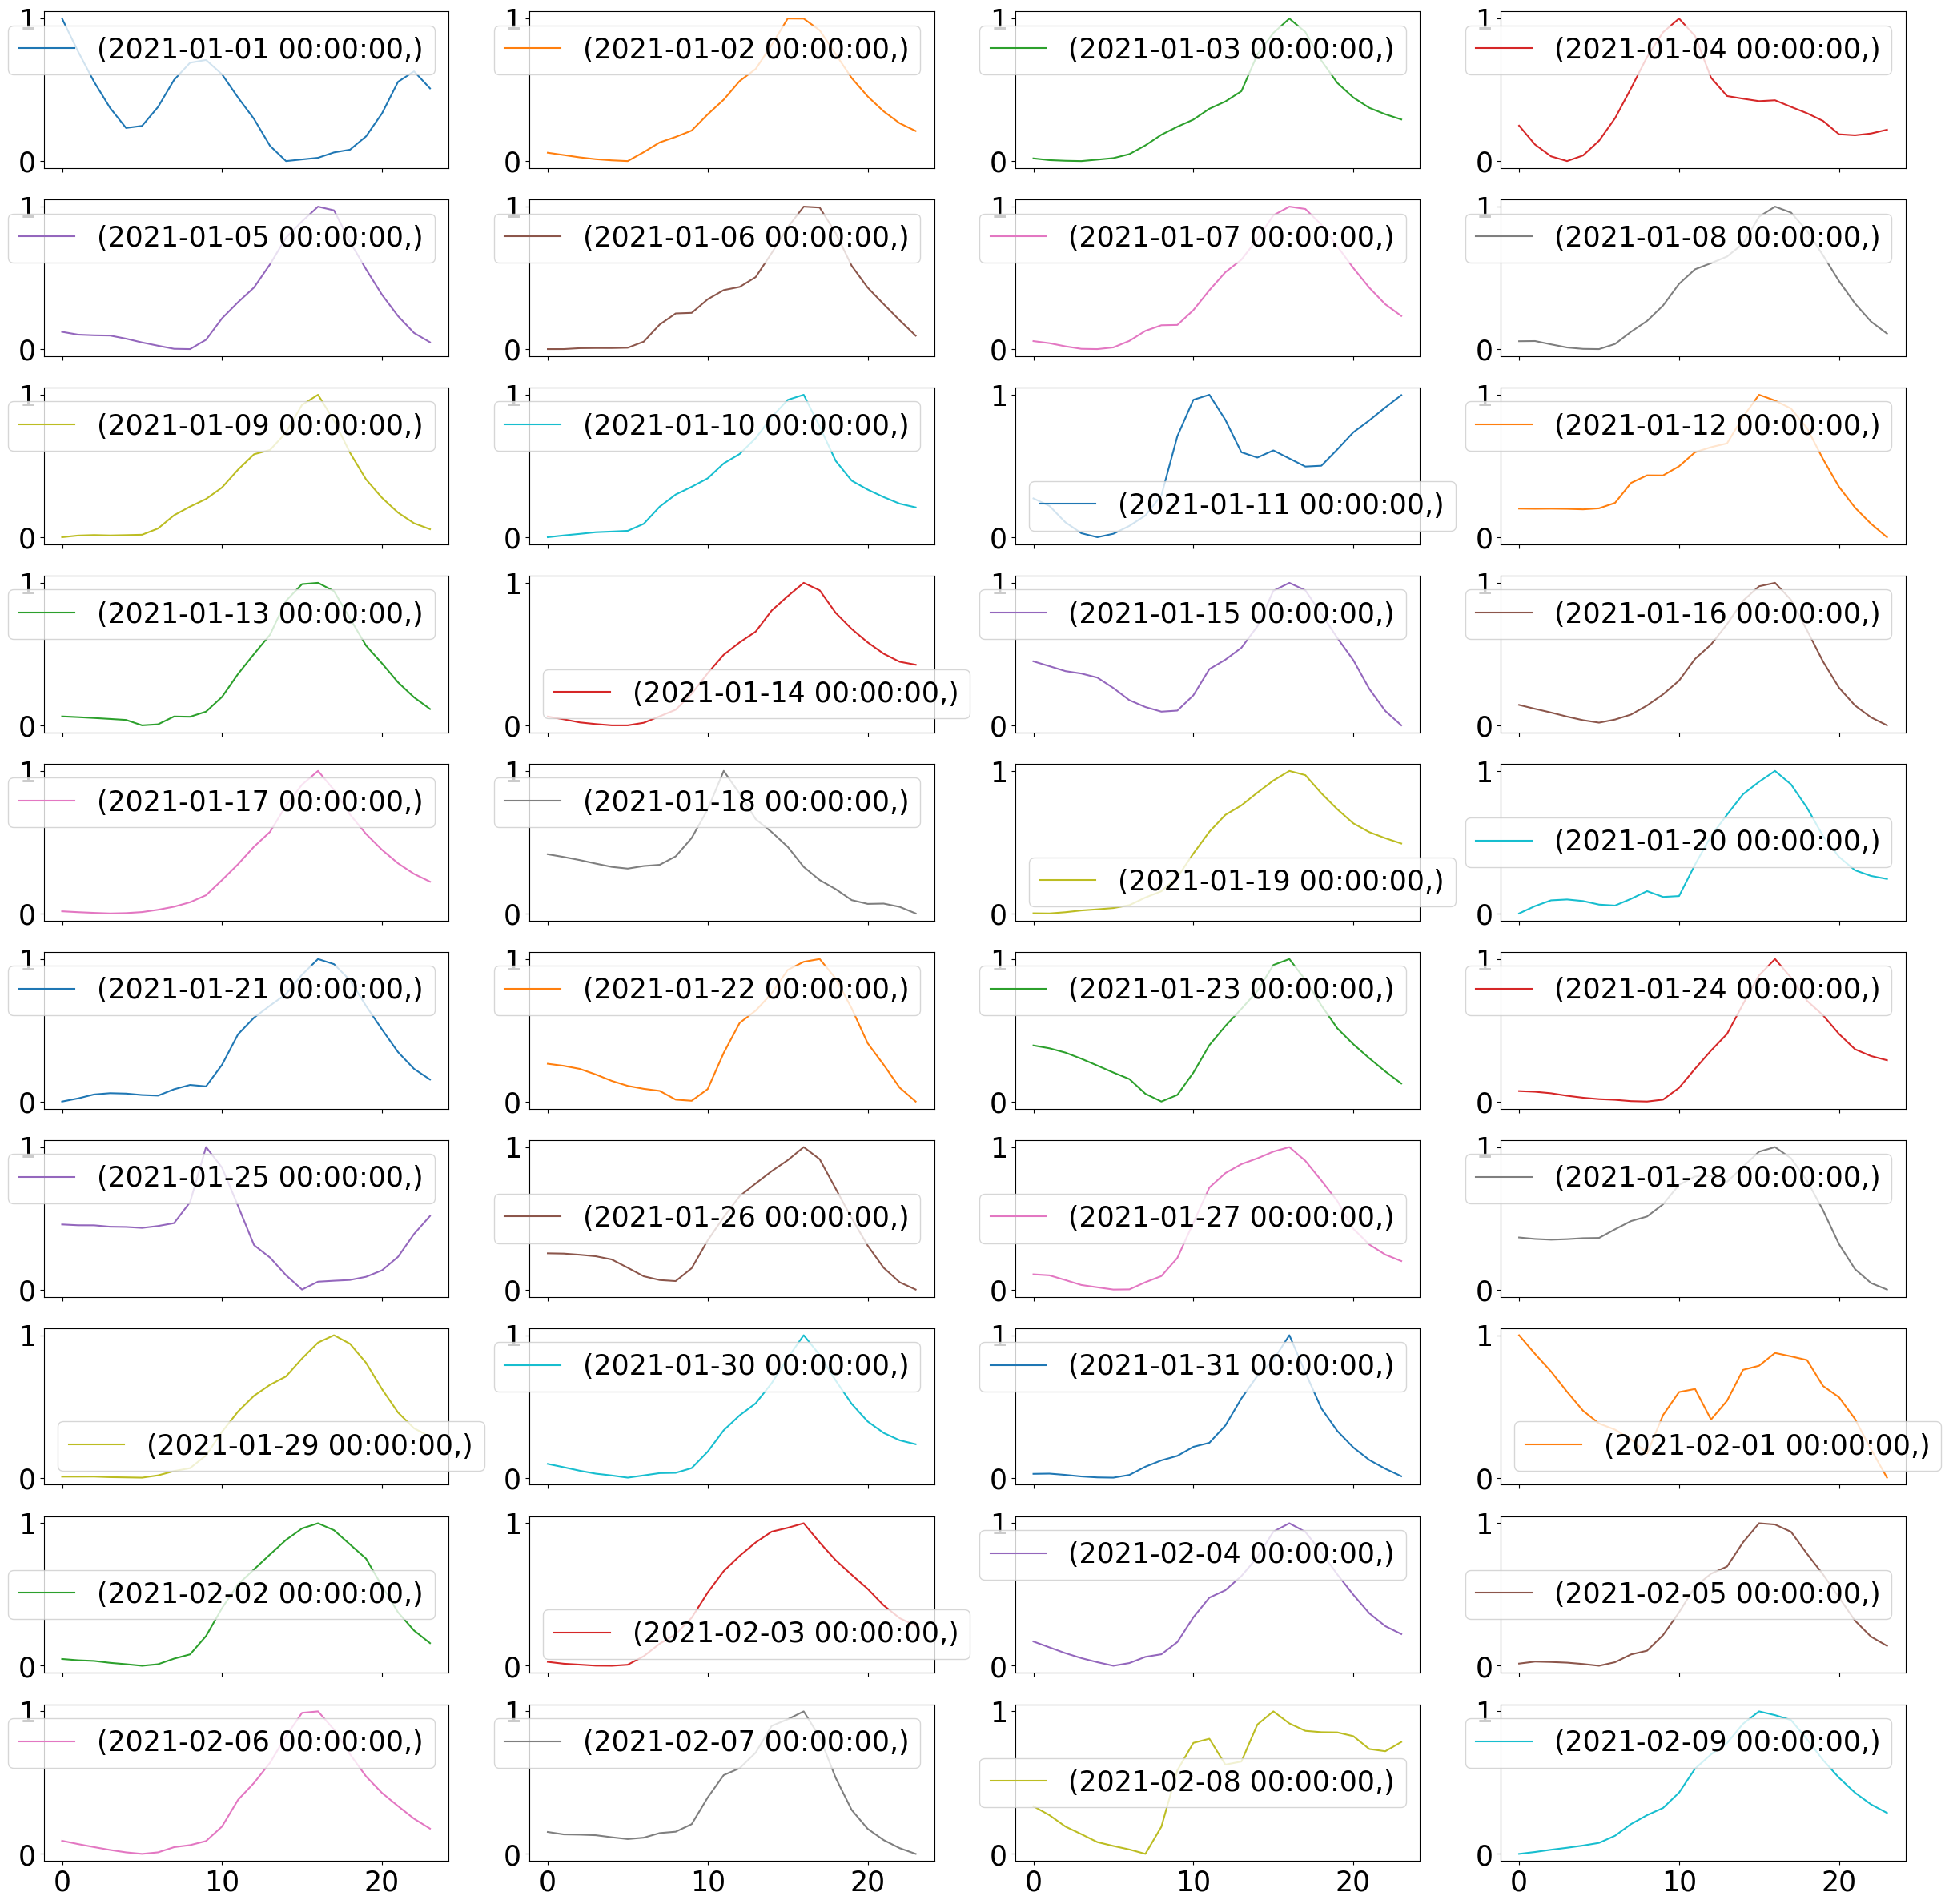

In [45]:
from Clust.clust.tool.plot_graph import plot_features
plot_features.plot_all_column_data_inSubPlot(data, fig_width, fig_height, fig_width_num = 4)

### 5-2. Som Clustering

In [46]:
data_series = data.to_numpy().transpose()
data_name = list(data.columns)
somV= SomClustering(data_series, data_name, 2, 2)
result = somV.train()
figdata, figdata2= somV.make_figs()
plt.show()

KeyboardInterrupt: 

In [ ]:
result